In [1]:
%matplotlib inline 

import dlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Notebook for Nudity Detection in Profile Pictures

As a general rule of thumb:

A small threshold (e.g., 5-30) might be used for detecting almost identical colors.
A medium threshold (e.g., 30-100) might be useful for more general cases where colors are similar but not necessarily identical.
A large threshold (e.g., 100-200) might be suitable when you want to classify colors into broader groups.

### Defining Useful Functions

In [2]:
def print_images(labels, images, _figsize=(10, 10)):
    """
        Function to plot a set of images
    :param _axis: 
    :param labels: the labels
    :param images: the images
    :param _figsize: the size of the figure
    :return: None
    """
    # assert labels.shape == images.shape
    plt.figure()
    f, axarr = plt.subplots(labels.shape[0], labels.shape[1], figsize=_figsize)

    rows, cols = labels.shape
    # Check the dimension of axarr and adjust accordingly
    if rows == 1 and cols == 1:
        axarr = np.array([[axarr]], dtype=object)  # Convert to 2D array
    elif rows == 1 or cols == 1:
        axarr = axarr.reshape(rows, cols)  # Convert to 2D array

    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            axarr[i, j].set_title(labels[i, j])
            axarr[i, j].imshow(images[i, j])

    plt.show()

def print_color_frequencies(colors, counts, prefix=""):
    """
        Function to print the color frequencies
    :param colors: the colors
    :param counts: the counts
    :param prefix: the prefix
    :return: None
    """
    frequencies = counts / sum(counts)
    # Display dominant colors and frequencies
    for i, (color, frequency) in enumerate(zip(colors, frequencies)):
        print(prefix + f"Color {i+1}: {color.astype(int)}, Frequency: {frequency:.2%}")


def get_mean_color(colors, counts):
    """
        Function to get the mean color
    :param colors: the colors
    :param counts: the counts
    :return: the mean color
    """
    result_color = np.array([0, 0, 0], dtype=np.float32)
    total_frequency = np.sum(counts)
    
    for color, frequency in zip(colors, counts):
        result_color += np.array(color, dtype=np.float32) * frequency / total_frequency
    
    return result_color.astype(int)
 
        
def crop_borders(perc, img):
    """
        Function to crop the borders of an image
    :param perc: the percentage that should be cropped on the borders 
    :param img: the image
    :return: the cropped image
    """
    h, w , _ = img.shape
    x_start = int(w * perc)
    y_start = int(h * perc)
    x_end = int(w * (1 - perc))
    y_end = int(h * (1 - perc))
    
    return img[y_start:y_end, x_start:x_end]

# Getting CNN detector for face. This is the trained model to face detection 
detector = dlib.cnn_face_detection_model_v1('Models/mmod_human_face_detector.dat')

def get_face_and_body(image):
    """
        Function to get the faces and bodies in an image
    :param image: the image
    :return: the faces and bodies
    """
    # detecting face 
    faces_rectangles = detector(image)
    bodies = []
    faces = []
    
    # getting arrau of faces and bodies
    for face in faces_rectangles: 
        x, y, w, h = face.rect.left(), face.rect.top(), face.rect.width(), face.rect.height()
        # getting the body
        body_x = int(max(x - w/2, 0))
        body_y = y + h
        body_w = int(w * 2)
        body_h = image.shape[0] - body_y
        faces.append((x, y, w, h))
        bodies.append((body_x, body_y, body_w, body_h))
        
    return faces, bodies

def color_distance(color1, color2):
    """
    Function to calculate the distance between two colors
    :param color1: 
    :param color2: 
    :return: the Euclidian Norm distance
    """
    return np.linalg.norm(color1 - color2)

def similarity_score(d):
    """
    Function to calculate the similarity score. 
    The maximum distance is 441.67 (255 * sqrt(3)). From RGB (0, 0, 0) to RGB (255, 255, 255)
    :param d: the distance between the colors
    :return: The similarity score. The higher the score, the more similar the colors are
    """
    d_norm = d / 441.67
    d_flipped = 1 - d_norm
    s_score = d_flipped * 100
    return max(0, min(100, s_score))  # Clamp score between 0 and 100

Printing Image


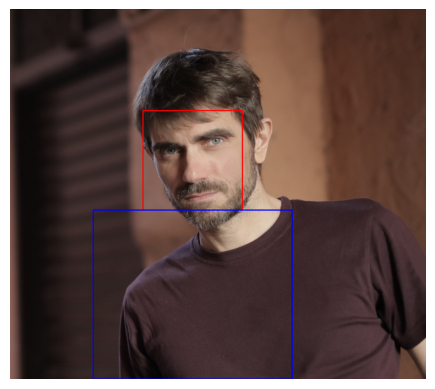

In [3]:
# Testing getting faces and bodies
%matplotlib inline 
#img1 = cv2.imread('Images/andrea-piacquadio-138.jpeg')
# Load the image using matplotlib (replace 'your_image.jpg' with the actual image file path)
img1 = mpimg.imread('Images/andrea-piacquadio-138.jpeg')
faces, bodies = get_face_and_body(img1)

print('Printing Image')
for (fx, fy, fw, fh), (bx, by, bw, bh) in zip(faces, bodies):
    cv2.rectangle(img1, (fx, fy), (fx + fw, fy + fh), (255, 0, 0), 5)
    cv2.rectangle(img1, (bx, by), (bx + bw, by + bh), (0, 0, 255), 5)
    
plt.imshow(img1)
plt.axis('off')  # Optional: Turn off axis labels and ticks
plt.show()

In [4]:
from sklearn.cluster import KMeans

def kmeans_color_clusters(image, n_colors=3):
    """
        Function to get the color clusters using KMeans
    :param image: the image
    :param n_colors: the number of colors
    :return: the colors, counts and labels
    """
    # convert to RGB from BGR
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    # cluster the pixel intensities
    kmeans = KMeans(n_clusters = n_colors)
    kmeans.fit(image)
    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)

    # cluster centroids, which can be interpreted as the dominant colors in the image.
    colors = kmeans.cluster_centers_
        
    return colors, counts, unique_labels

def kmeans_get_dominant_color(colors, counts):
    # colors, counts, labels =  kmeans_get_color_frequencies(image, n_colors)
    print(colors)
    print(counts)
    dominant = colors[np.argmax(counts)]
    return dominant.astype(int)


def color_padding(image, padding_color, l_pad_width): 
    # Define the padding: ((top, bottom), (left, right), (channel padding))
    l_pad_width = ((0, 2), (0, 0), (0, 0))
    # Pad the array with the specific color
    padded_image = np.pad(image, l_pad_width, mode='constant', constant_values=padding_color)
    return padded_image


def concatenate_bars(face_chart, body_chart):    
    # Define the padding: ((top, bottom), (left, right), (channel padding))
    l_pad_width = ((0, 2), (0, 0), (0, 0))
    
    # Pad the array
    face_chart = np.pad(face_chart, l_pad_width, mode='constant', constant_values=255)
    
    # Vertical concatenate the charts
    return np.concatenate((face_chart, body_chart), axis=0)

In [21]:
# TEST PACKAGE DOMINANT COLOR (DID NOT FIND THAT USEFUL) 
from imagedominantcolor import DominantColor
img_dominant_color = DominantColor('Images/pexels-nicole-berro-1994818.jpg')
print(img_dominant_color.dominant_color)
print(img_dominant_color.rgb)
print(img_dominant_color.total_pixels)
repr(img_dominant_color)

r
(181, 24, 34)
256


'DominantColor(r:181 g:24 b:34 l:17; dominant_color:r; resize_value:16; minimum_percent_difference_of_rgb:10)'

In [5]:
def bar_histogram(colors, labels, n_clusters):
    """
        Function to get the bar histogram
    :param colors: the centroids of the clusters, which can be interpreted as the dominant colors in the image.
    :param labels: the labels
    :param n_clusters: the number of clusters
    :return: the bar histogram
    """
        
    #initialize the bar chart representing the relative frequency
    #labels form 0 to no. of clusters
    num_labels = np.arange(0, n_clusters+1)
   
    #create frequency count tables    
    (hist, _) = np.histogram(labels, bins = num_labels)
    hist = hist.astype("float")
    hist /= hist.sum()
    
    #descending order sorting as per frequency count
    colors = colors[(-hist).argsort()]
    hist = hist[(-hist).argsort()] 
    
    #creating empty chart
    chart = np.zeros((50, 500, 3), np.uint8)
    start = 0
    
    #creating color rectangles
    for i in range(n_clusters):
        end = start + hist[i] * 500
        
        #getting rgb values
        r = colors[i][0]
        g = colors[i][1]
        b = colors[i][2]
        
        #using cv2.rectangle to plot colors
        cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
        start = end	
    
    return chart

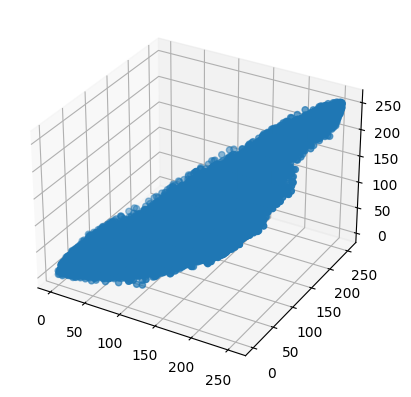

In [19]:
# Test Plotting the 3D Chart of the colors
import matplotlib.pyplot as plt
import cv2

#read image
#img = cv2.imread('Images/andrea-piacquadio-138.jpeg')

#convert from BGR to RGB
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = mpimg.imread('Images/pexels-nicole-berro-1994818.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#get rgb values from image to 1D array
r, g, b = cv2.split(img)
r = r.flatten()
g = g.flatten()
b = b.flatten()

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r, g, b)
plt.show()

In [ ]:
# EXECUTING ALL TOGETHER
img1 = mpimg.imread('Images/pexels-nicole-berro-1994818.jpg')
faces, bodies = get_face_and_body(img1)
l_num_clusters = 1
# I am gonna iterate through persons 
for face, body in zip(faces, bodies):
    cropped_face = crop_borders(0.2, img1[face[1]:face[1]+face[3], face[0]:face[0]+face[2]])
    cropped_body = crop_borders(0.2, img1[body[1]:body[1]+body[3], body[0]:body[0]+body[2]])
    
    # getting face and body dominant colors
    f_colors, f_counts, f_labels =  kmeans_color_clusters(cropped_face, l_num_clusters)
    print_color_frequencies(f_colors, f_counts, prefix="Face ")
    color_face = kmeans_get_dominant_color(f_colors, l_num_clusters)
    
    b_colors, b_counts, b_labels =  kmeans_color_clusters(cropped_body, l_num_clusters)
    print_color_frequencies(b_colors, b_counts, prefix="Body ")
    color_body = kmeans_get_dominant_color(b_colors, l_num_clusters)
    
    # getting distance between colors
    distance = color_distance(color_face, color_body)
    print("Distance: ", distance)
    score = similarity_score(distance)
    print("Score: ", score)


In [38]:
# FUNCTION TO DEBUG AN IMAGE
def debug_image(image, l_num_clusters=1):
    print("IMAGE DEBUG: ", image.shape)
    d_faces, d_bodies = get_face_and_body(image)
    # I am gonna iterate through persons 
    for l_face, l_body in zip(d_faces, d_bodies):
        # First we will print the image with the faces and bodies detected
        dbg_cropped_face = crop_borders(0.3, image[l_face[1]:l_face[1] + l_face[3], l_face[0]:l_face[0] + l_face[2]])
        dbg_cropped_body = crop_borders(0.2, image[l_body[1]:l_body[1] + l_body[3], l_body[0]:l_body[0] + l_body[2]])
        # Drawing the rectangles
        cv2.rectangle(image, (l_face[0], l_face[1]), (l_face[0] + l_face[2], l_face[1] + l_face[3]), (255, 0, 0), 4)
        cv2.rectangle(image, (l_body[0], l_body[1]), (l_body[0] + l_body[2], l_body[1] + l_body[3]), (0, 0, 255), 4)
        
        # Printing the image
        dbg_images = np.array([[image, dbg_cropped_face, dbg_cropped_body]], dtype=object)
        dbg_labels = np.array([['Original', 'Face (cropped)', 'Body (cropped)']], dtype=object)
        print_images(dbg_labels, dbg_images, _figsize=(12, 12))
        
        # == face operations ==
        f_colors, f_counts, f_labels =  kmeans_color_clusters(dbg_cropped_face, l_num_clusters - 1)
        print_color_frequencies(f_colors, f_counts, prefix="Face ")
        #color_face = kmeans_get_dominant_color(f_colors, f_counts)
            
        b_colors, b_counts, b_labels =  kmeans_color_clusters(dbg_cropped_body, l_num_clusters)
        print_color_frequencies(b_colors, b_counts, prefix="Body ")
        color_body = kmeans_get_dominant_color(b_colors, b_counts)
        
        mean_color_face = get_mean_color(f_colors, f_counts)
        
        # getting horizontal histograms
        chart_face = bar_histogram(f_colors, f_labels, l_num_clusters - 1)
        chart_body = bar_histogram(b_colors, b_labels, l_num_clusters)
        
        # Create a numpy array with the specified color
        mean_color_chart = np.full((chart_face.shape[0], chart_face.shape[1], 3), mean_color_face, dtype=np.uint8)
        chart_face = concatenate_bars(chart_face, mean_color_chart)
        
        # Concatenating the charts
        l_chart = concatenate_bars(chart_face, chart_body)
        print("Dominant Body Color: ", color_body)
        print("Mean Face Color: ", mean_color_face)
        l_distance = color_distance(mean_color_face, color_body)
        print("Euclidian Norm Distance: ", l_distance)
        l_score = similarity_score(l_distance)
        print("Score: ", l_score)
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(l_chart)
        
        

# TESTS START HERE

IMAGE DEBUG:  (2977, 2322, 3)


<Figure size 640x480 with 0 Axes>

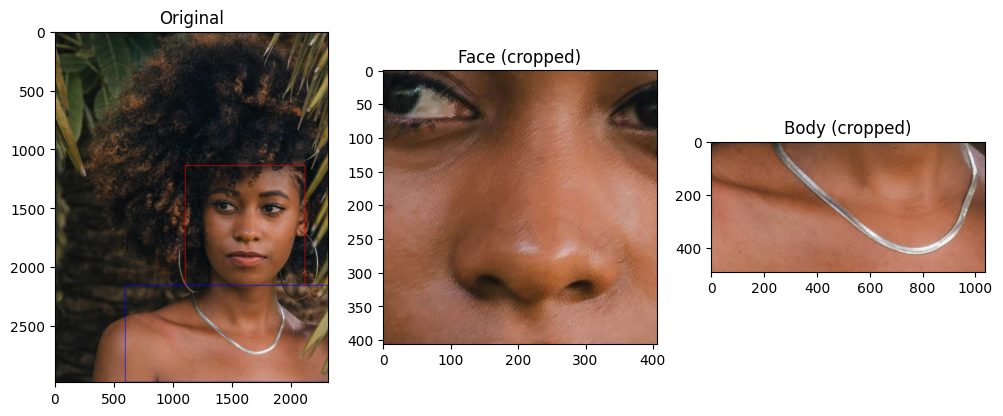

Face Color 1: [143  93  70], Frequency: 100.00%
Body Color 1: [141  85  58], Frequency: 38.53%
Body Color 2: [185 124 101], Frequency: 61.47%
Dominant Body Color:  [185 124 101]
Mean Face Color:  [143  93  70]
Euclidian Norm Distance:  60.71243694664216
Score:  86.25389160535192


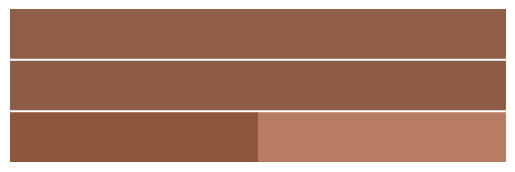

In [39]:
img_nicole = mpimg.imread('Images/pexels-nicole-berro-1994818.jpg')
# img1 = mpimg.imread('Images/andrea-piacquadio-138.jpeg')
debug_image(img_nicole, 2)

IMAGE DEBUG:  (5264, 4211, 3)


<Figure size 640x480 with 0 Axes>

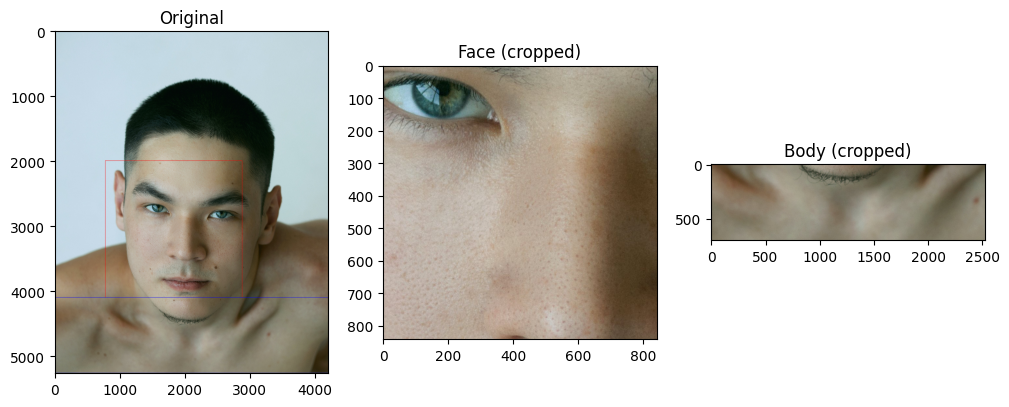

Face Color 1: [158 144 127], Frequency: 100.00%
Body Color 1: [109 100  79], Frequency: 36.76%
Body Color 2: [146 139 122], Frequency: 63.24%
Dominant Body Color:  [146 139 122]
Mean Face Color:  [158 144 127]
Euclidian Norm Distance:  13.92838827718412
Score:  96.84642645477753


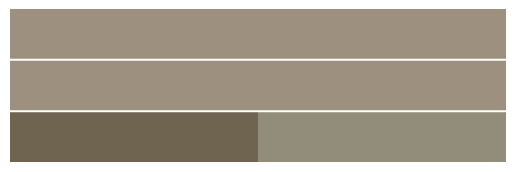

In [40]:
image_rada = mpimg.imread('Images/pexels-rada-aslanova-18620713.jpg')
# imagex = cv2.imread('Images/pexels-rada-aslanova-18620713.jpg')
debug_image(image_rada, 2)

IMAGE DEBUG:  (5120, 7680, 3)


<Figure size 640x480 with 0 Axes>

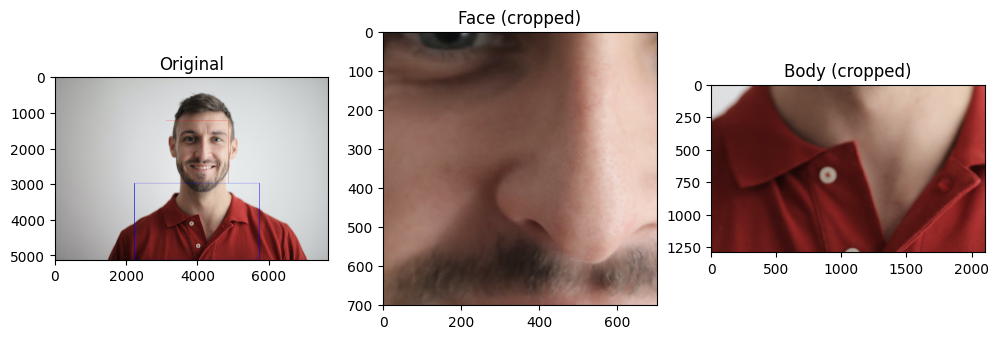

Face Color 1: [137 103  92], Frequency: 100.00%
Body Color 1: [99 35 31], Frequency: 77.87%
Body Color 2: [190 160 144], Frequency: 22.13%
Dominant Body Color:  [99 35 31]
Mean Face Color:  [137 103  92]
Euclidian Norm Distance:  98.93937537704592
Score:  77.59880105575522


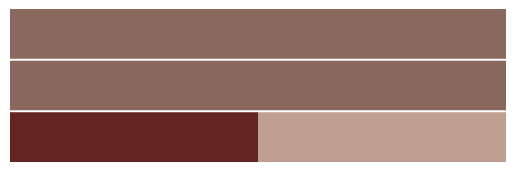

In [41]:
debug_image(mpimg.imread('Images/pexels-andrea-piacquadio-3777943.jpg'), 2)

IMAGE DEBUG:  (2187, 2460, 3)


<Figure size 640x480 with 0 Axes>

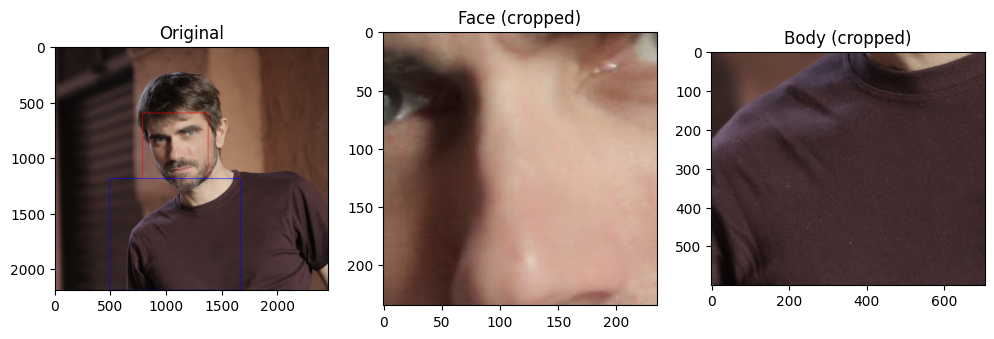

Face Color 1: [160 124 109], Frequency: 100.00%
Body Color 1: [64 44 47], Frequency: 97.83%
Body Color 2: [151 127 120], Frequency: 2.17%
Dominant Body Color:  [64 44 47]
Mean Face Color:  [160 124 109]
Euclidian Norm Distance:  139.49910393977447
Score:  68.41553559449942


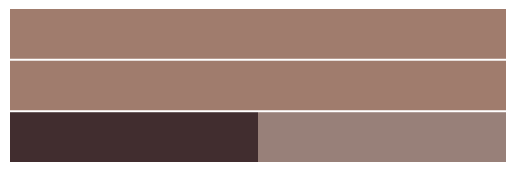

In [42]:
debug_image(mpimg.imread('Images/andrea-piacquadio-138.jpeg'), 2)